# Automatic License Plate Recognition System for Parking Lot

For our project, we will focus on implementing a sign-in system in a parking lot. Such a system will check a vehicle in a parking lot noting the vehicles license plate and the time of the checkin and checkout. Other features such as number of passengers, colour of the vehicle, etc. can be derived from an image sequence or a video sequence of the vehicles at the checkin gate set at license plate level and pointing perpendicular to the plate to minimize skew.

To implement this design, we first must build a dataset with the appropriate characters. For the English letters, we can use the Char74k dataset. This famous dataset contains an assortment of images of 0-9 and A-Z and can be conveniently found at the following link http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/.

![Char74k](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/Samples/english.png)

First, we will read in a number of images of 0-9 and A-Z to train our letter recognition model. Because of limited images, we can use Kera's image generator to create more training data. We have selected to slightly rotate, stretch, shift, but not flip the images. Then, we will rename the images in a character_imagenumber fashion.

Once the training images are prepared, we will read them into an array to hold the image (image_array) and another array to hold the ground truth of that image (target_data). 

### Creating dataset and reading in data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
# With the given data, generate more based on the given data
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest')
for ltr in letters:
    for idx in range(0,40):
        img_path =  'train-3/'+ltr+'/'+ltr+'_'+str(idx)+'.jpg'
        if os.path.exists(img_path)==False:
                continue
        else:
            img = load_img(img_path)  
            
            x = img_to_array(img)  
            x = x.reshape((1,) + x.shape)  

            i = 0
            pic=20
            for batch in datagen.flow(x, batch_size=1,save_to_dir='train/'+ltr+'/', save_prefix=ltr, save_format='jpeg'):
                i += 1
                pic+=1
                if i > 1000:
                    break  

In [ ]:
# Rename the image paths to a uniform fashion
paths = ['train/'+j+'/' for j in letters]
for path, ltr in zip(paths, letters):
    files = os.listdir(path)
    i = 0

    for file in files:
        os.rename(os.path.join('train/'+ltr, file), os.path.join(path, ltr+'_'+str(i)+'.jpg'))
        i = i+1

### Train Model

We will use SVM with a linear kernel as the model with K=10 fold validation, then save the model.

In [1]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu

In [2]:
letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]
letters_num = [i for i in range(0,len(letters))]

In [3]:
def read_training_data(training_directory):
    image_data = []
    target_data = []
    for each_letter in letters:
        # read in 30 images for each character
        for each in range(30):
            image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
            if os.path.exists(image_path)==True:
                try:
                
                    img_details = imread(image_path, as_grey=True)
                    # converts each character image to binary image
                    binary_image = img_details < threshold_otsu(img_details)
                    # flatten then add to the image_data
                    flat_bin_image = binary_image.reshape(-1)
                    image_data.append(flat_bin_image)
                    target_data.append(each_letter)
                except OSError as e:
                    os.remove(img_path)
            else:
                continue
                
    return (np.array(image_data), np.array(target_data))



In [4]:
def cross_validation(model, train_data, train_label,num_of_fold):
    accuracy_result = cross_val_score(model, train_data, train_label,cv=num_of_fold)
    print("Cross Validation Result for ", str(num_of_fold), "-fold")

    print(accuracy_result * 100)

In [6]:
current_dir = os.path.dirname(os.path.realpath("__file__"))
training_dataset_dir = os.path.join(current_dir, 'train')
image_data, target_data = read_training_data(training_dataset_dir)

svc_model = SVC(kernel='linear', probability=True)
cross_validation(svc_model, image_data, target_data,10)

Cross Validation Result for  10 -fold
[ 83.33333333  97.05882353  95.09803922  96.07843137  95.09803922
  95.09803922  96.07843137  95.09803922  96.03960396  98.        ]


In [7]:
svc_model.fit(image_data, target_data)

save_directory = os.path.join(current_dir, 'models/svc/')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
joblib.dump(svc_model, save_directory+'/svc.pkl')

['/Users/xiaosg/EL9123Labs/Project/project/models/svc//svc.pkl']

In [8]:
print(target_data)

['0' '0' '0' ..., 'Z' 'Z' 'Z']


### Load Image

To demonstrate the functionality of our system, we will show example.

In [9]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

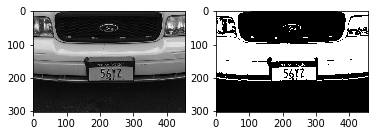

In [83]:
car_image_path="./cars/56Y2.jpg"
car_image = imread(car_image_path, as_grey=True)

gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap="gray")
plt.show()

### License Plate Detection

Now we use localization technique to figure out where in the image is a license plate. We characterize this as a long rectangular shape for the dimensions. For this project, we first plot the image with the pixels, then come up with a general rule of the dimensions for the smallest/largest height/width a plate could be. This general rule would apply to almost all license plates. This is similiar to the technique used in Lab 6 for the MNIST data to draw a bounding box.

In [33]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches

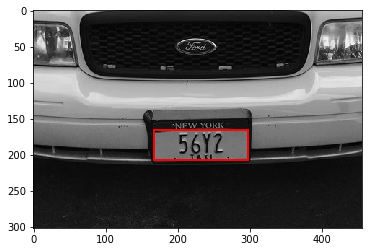

In [88]:
# this gets all the connected regions and allows use to iterate through them
label_image = measure.label(binary_car_image)


# From observation of the standard universal license plate, these are the dimensions we came up with
#plate_dimensions = (0.3*label_image.shape[0], 0.6*label_image.shape[0], 0.5*label_image.shape[1], 0.8*label_image.shape[1])
plate_dimensions = (0.1*label_image.shape[0], 0.25*label_image.shape[0], 0.25*label_image.shape[1], 0.5*label_image.shape[1])


min_height, max_height, min_width, max_width = plate_dimensions

plate_objects_cordinates = []
plate_like_objects = []
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray");

for region in regionprops(label_image):
    if region.area < 40:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row - min_row
    region_width = max_col - min_col
    
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        plate_like_objects.append(binary_car_image[min_row:max_row,
                                  min_col:max_col])
        plate_objects_cordinates.append((min_row, min_col,
                                              max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
    
plt.show()

### Character Segmentation

In [13]:
import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import matplotlib.pyplot as plt

/Users/xiaosg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/xiaosg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/xiaosg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/xiaosg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


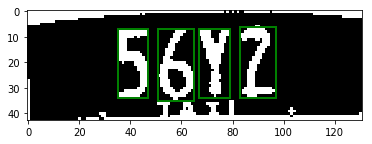

[83, 35, 51, 67]

In [89]:
# Invert the colors b->w, w->b
license_plate = np.invert(plate_like_objects[0])
#license_plate = plate_like_objects[0]

labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

# Again from observation, we note the approximate proportions of the characters on the plate
character_dimensions = (0.4*license_plate.shape[0], 0.8*license_plate.shape[0], 0.05*license_plate.shape[1], 0.4*license_plate.shape[1])
#character_dimensions = (0.55*license_plate.shape[0], 0.85*license_plate.shape[0], 0.05*license_plate.shape[1], 0.25*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []

for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="green",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # keep track of the arrangement of the characters
        column_list.append(x0)

plt.show()

column_list

### Character Prediction

In [90]:
import os
from sklearn.externals import joblib

# load the model
current_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(current_dir, 'models/svc/svc.pkl')
model = joblib.load(model_dir)

classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]
    
# arrange in correct order
column_list_copy = column_list[:]
column_list.sort()


temp_string = ''
for each in column_list:
    temp_string += plate_string[column_list_copy.index(each)]
    
#predicted_plate = temp_string[len(temp_string)-1]+temp_string[0:len(temp_string)-1]
print(temp_string)


56Y2


###  Output
Check if the car's license plate has been on the list already 
* if yes, that means the car is going out, then we output the time it parked
* if no, that means it is a newcoming car, we will register it onto the list

In [ ]:
import pandas as pd
from datetime import datetime
import csv

names =['LP','Time']
carlist = pd.read_csv('./list.csv',header=None,index_col=None,names=names,na_values='?')
LPs = (np.array(carlist.LP)).tolist()
Times = (np.array(carlist.Time)).tolist()
LP = predicted_plate
T = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

if LP in LPs:
    ind = np.squeeze(np.where(LP in LPs))
    s1 = Times[ind] # getting time corrsponding to the license plate
    FMT = '%Y-%m-%d %H:%M:%S'
    tdelta = datetime.strptime(T, FMT) - datetime.strptime(s1, FMT)
    print('Thanks for parking with us, your parking time is',str(tdelta))
    
    LPs.remove(LP) # deleting the car going out
    Times.remove(s1)
    lines = [np.zeros(len(LP)),np.zeros(len(LP))]
    with open('list.csv', 'w',newline='') as csvfile:
        writer = csv.writer(csvfile)
        k = 0
        for k in range (len(LPs)):
            lines[k] = [LPs[k],Times[k]]
            writer.writerow(lines[k])
else:
    newitem = (LP,T) # adding the new car
    with open('list.csv', 'a',newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([])
        writer.writerow(newitem)
        print('Welcome to Parking Lot')

### Show the already parked cars

In [92]:
carlist = pd.read_csv('./list.csv',header=None,index_col=None,names=names,na_values='?')        
print('existing cars:')
print(carlist)

existing cars:
         LP                 Time
0        LP                 Time
1   FGJ3553    2017/12/12 20:490
2       NaN                  NaN
3   FGJ3553    2017/12/12 20:490
4       NaN                  NaN
5   FGJ3553    2017/12/12 20:490
6       NaN                  NaN
7   FGJ3553    2017/12/12 20:490
8       NaN                  NaN
9   FGJ3553    2017/12/12 20:490
10      NaN                  NaN
11  FGJ3553    2017/12/12 20:490
12      NaN                  NaN
13  FGJ3553    2017/12/12 20:490
14      NaN                  NaN
15  FGJ3553    2017/12/12 20:490
16      NaN                  NaN
17  FGJ3553    2017/12/12 20:490
18      NaN                  NaN
19  FGJ3553    2017/12/12 20:490
20      NaN                  NaN
21  FGJ3553    2017/12/12 20:490
22      NaN                  NaN
23  FGJ3553    2017/12/12 20:490
24      NaN                  NaN
25  FGJ3553    2017/12/12 20:490
26      NaN                  NaN
27  FGJ3553    2017/12/12 20:490
28      NaN                 